# Ionosphere

- https://archive.ics.uci.edu/ml/datasets/ionosphere

## Introduction

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this databse are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

## Initialization

In [1]:
RANDOM_SEED=42#@param{type:'integer'}
BASE_URL="https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/"#@param{type:'string'}


### Imports

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

We'll first have to download the dataset itself

In [3]:
import requests
from os.path import join

response = requests.get(join(BASE_URL, 'ionosphere.data'))
with open('ionosphere.csv', 'w+') as writer:
  writer.write(response.text)

In [4]:
target_name = 'target'
feature_names = [ f'col_{col}' for col in range(0, 34) ]

In [5]:
dataframe = pd.read_csv('ionosphere.csv', names=[*feature_names, target_name])
dataframe.shape

(351, 35)

## Data Analysis

Meant to extract more insight about the data that we have

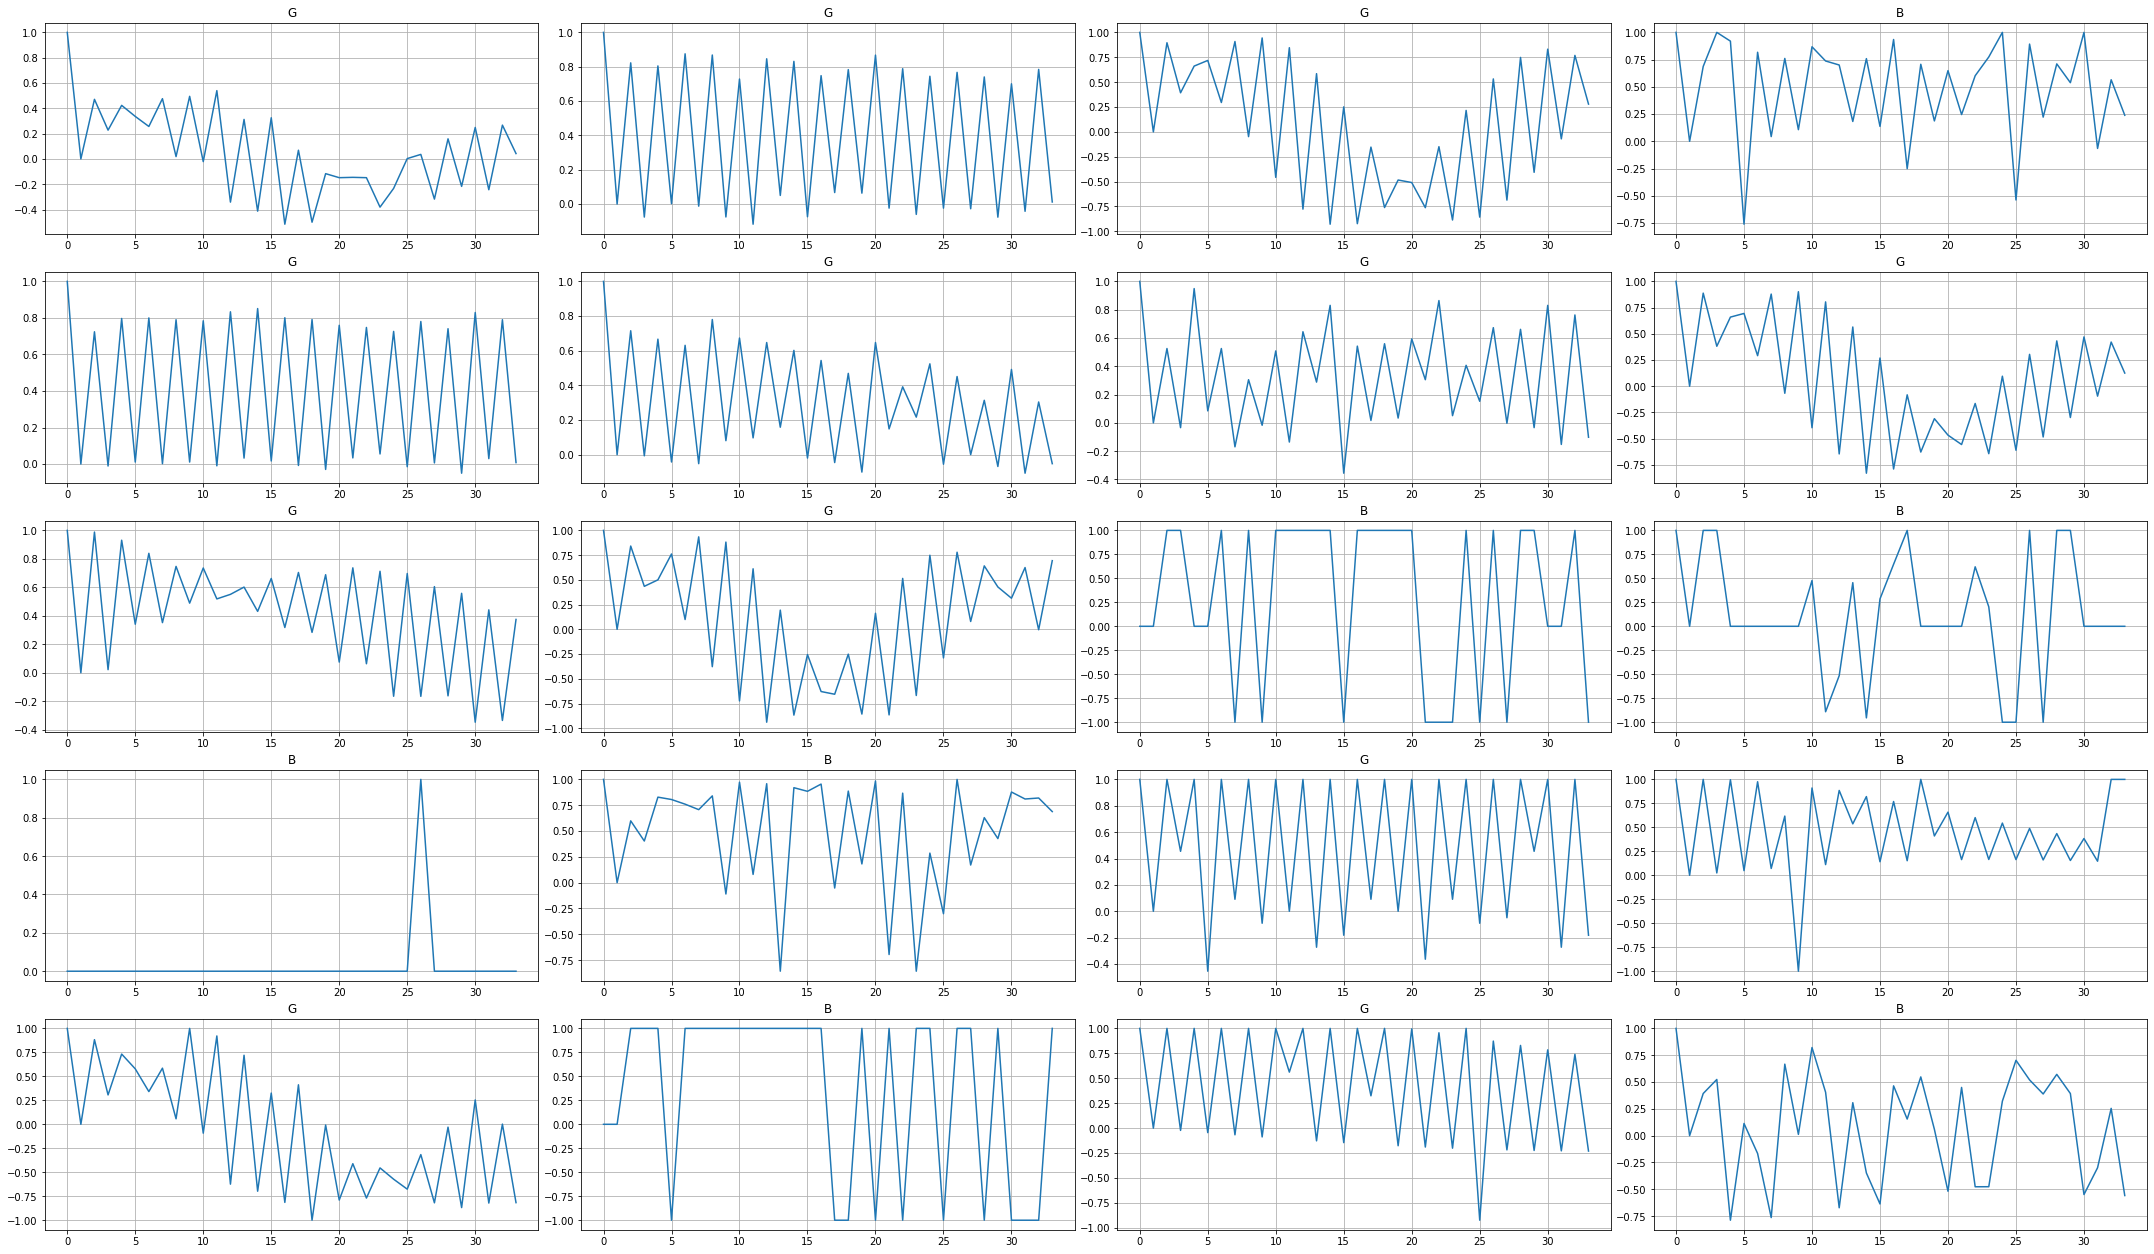

In [6]:
n_features = len(feature_names)
rows, cols = (5, 4)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7.5, rows * 3.5))
axes.flatten()
random_sonars = dataframe.sample(rows * cols).values
for index, row in enumerate(random_sonars):
  ax = axes[int(index / cols), int(index % cols)]
  ax.set_title(row[n_features].title())
  ax.grid()
  ax.plot(row[0:n_features])
plt.tight_layout(pad=1.0, h_pad=.5, w_pad=.5)

### Pattern differences

Since we're analyzing signals, we can try to look for a pattern. For that we can use the mean of each label and compare them

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: D

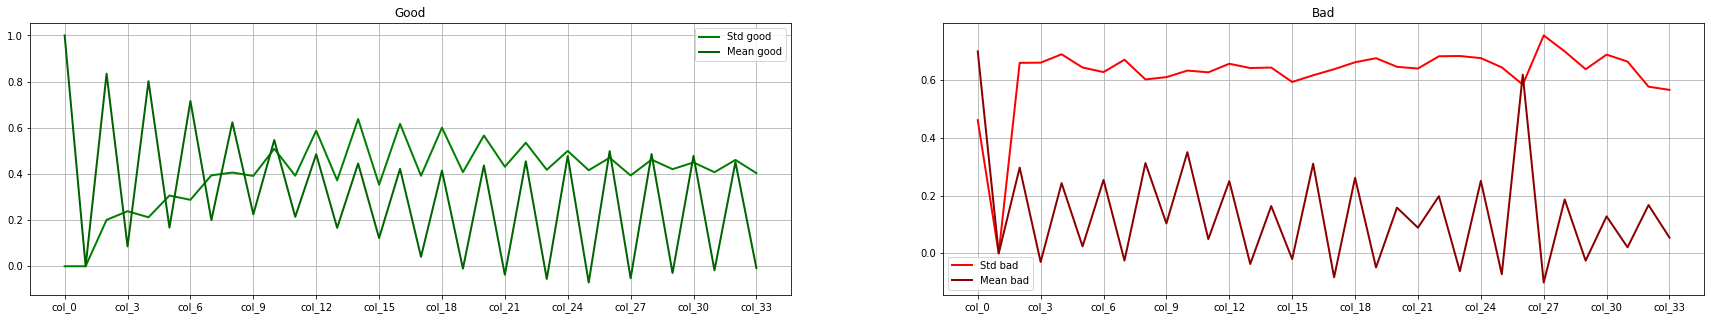

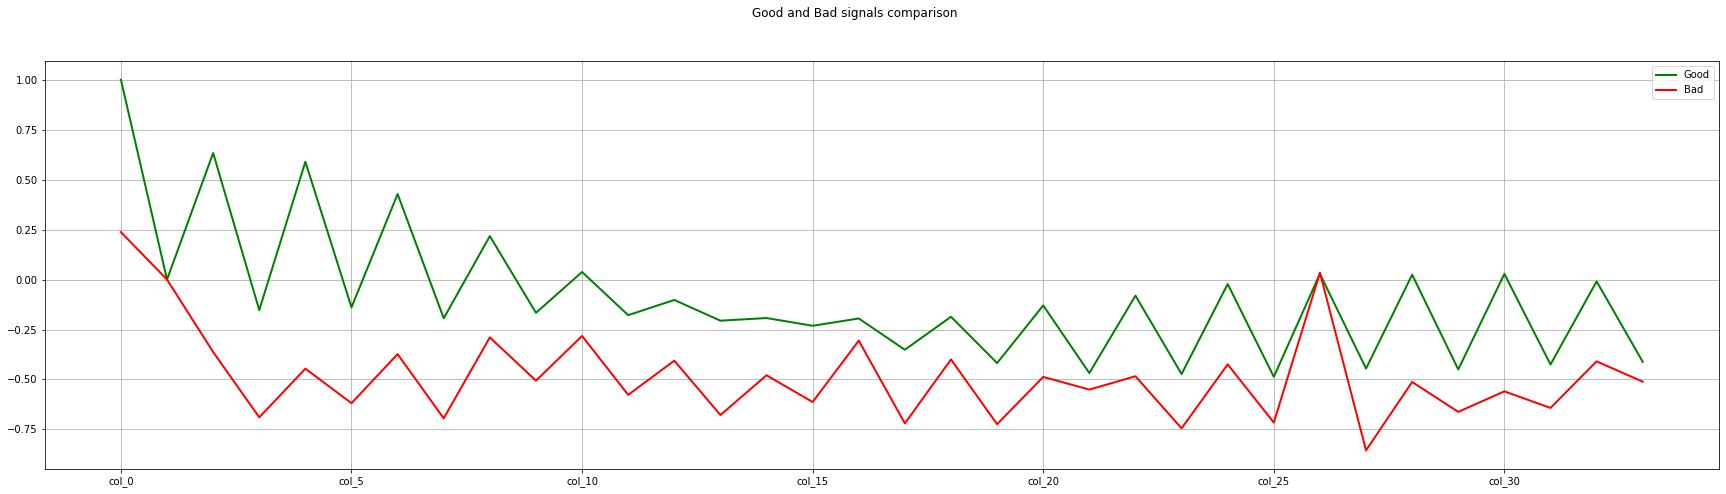

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(30, 5))

good_agroupation = dataframe[ dataframe['target'] == 'g' ]
bad_agroupation = dataframe[ dataframe['target'] == 'b' ]

current_ax = axes[0]
current_ax.set_title('Good')
current_ax.set_xticks(range(0, n_features, 3))
good_agroupation.std().plot(ax=current_ax, color='green', label='Std good', lw=2)
good_agroupation.mean().plot(ax=current_ax, color='darkgreen', label='Mean good', lw=2)
current_ax.grid()
current_ax.legend(['Std good', 'Mean good'])

current_ax = axes[1]
current_ax.set_title('Bad')
current_ax.set_xticks(range(0, n_features, 3))
bad_agroupation.std().plot(ax=current_ax, color='red', label='Std bad', lw=2)
bad_agroupation.mean().plot(ax=current_ax, color='darkred', label='Mean bad', lw=2)
current_ax.grid()
current_ax.legend(['Std bad', 'Mean bad'])

plt.figure(figsize=(30, 7.5))
plt.suptitle('Good and Bad signals comparison')
# good_agroupation.std().plot(color='green', label='Std good', lw=2)
# good_agroupation.mean().plot(color='darkgreen', label='Mean good', lw=2)
# bad_agroupation.std().plot(color='red', label='Std bad', lw=2)
# bad_agroupation.mean().plot(color='darkred', label='Mean bad', lw=2)

((good_agroupation.mean() - good_agroupation.std())).plot(color='green', label='Good', lw=2)
((bad_agroupation.mean() - bad_agroupation.std())).plot(color='red', label='Bad', lw=2)
plt.grid()
# plt.yticks(np.array(range(0, 101, 10)) / 100)
# plt.xticks(range(0, n_features))
plt.legend(['Good', 'Bad'])

## Data Preparation

Making sure the data is quality data

### Backup

But first of all, a quick backup, just in case

In [8]:
df = dataframe.copy(deep=True)

### Target conversion

The target value is non-numeric, we should fix that so that our model can actually understand it

In [9]:
reverse_target_dict = {1: 'Good', 0: 'Bad'}
df[target_name] = np.where(df[target_name] == 'g', 1, 0)

## Data Science

Preparing the data for our model, the last touches

### Imports

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

### Assignment

In [11]:
X = df[feature_names]
y = df[target_name]

### Imbalancement

Something to consider when tackling a classification problem

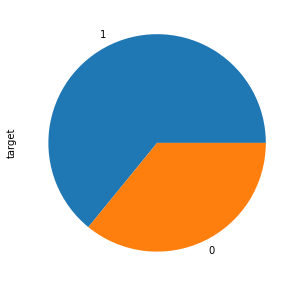

In [12]:
plt.figure(figsize=(5, 5))
y.value_counts().plot.pie()

We could quickly fix it by undersampling

In [13]:
# from imblearn.under_sampling import RandomUnderSampler
# X, y = RandomUnderSampler(random_state=RANDOM_SEED).fit_resample(X, y)

But for this case scenario, loosing too many data wouldn't be worth it

### Splitting

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED, stratify=y, shuffle=True)

### XGBoost

In [15]:
from xgboost import XGBClassifier

def build_xgboost() -> Pipeline:
  steps = [
    ('model', XGBClassifier(random_state=RANDOM_SEED)),
  ]

  return Pipeline(steps=steps)

In [16]:
clf_xgb = build_xgboost()
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)
print('normal', clf_xgb.score(X_test, y_test))
print('balanced', balanced_accuracy_score(y_test, y_pred_xgb))

normal 0.971830985915493
balanced 0.9691304347826086


#### Confusion Matrix

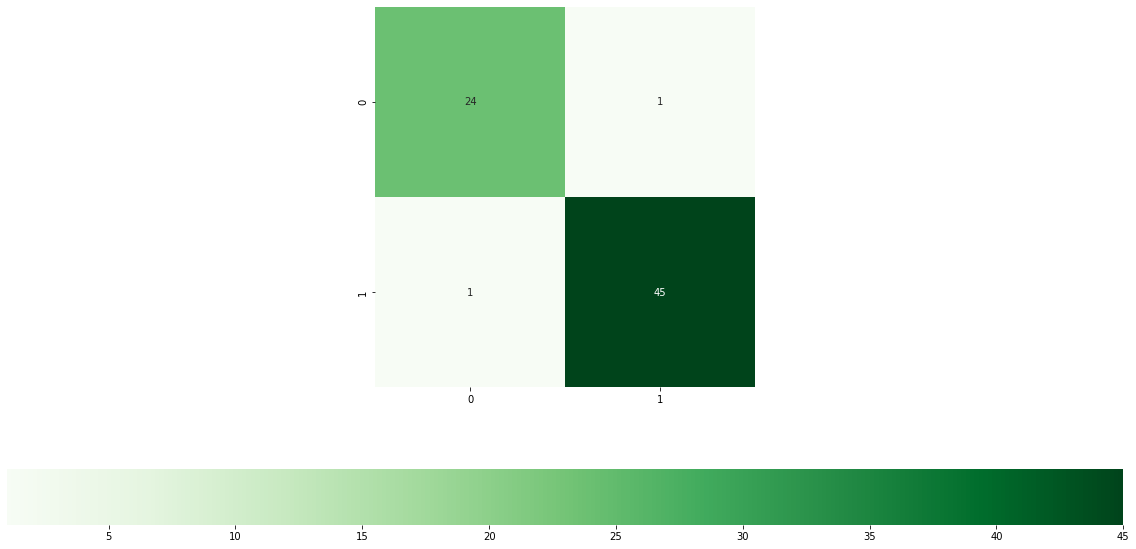

In [17]:
plt.figure(figsize=(20, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, square=True, cbar_kws={'orientation': 'horizontal'}, cmap='Greens')

#### Evaluation

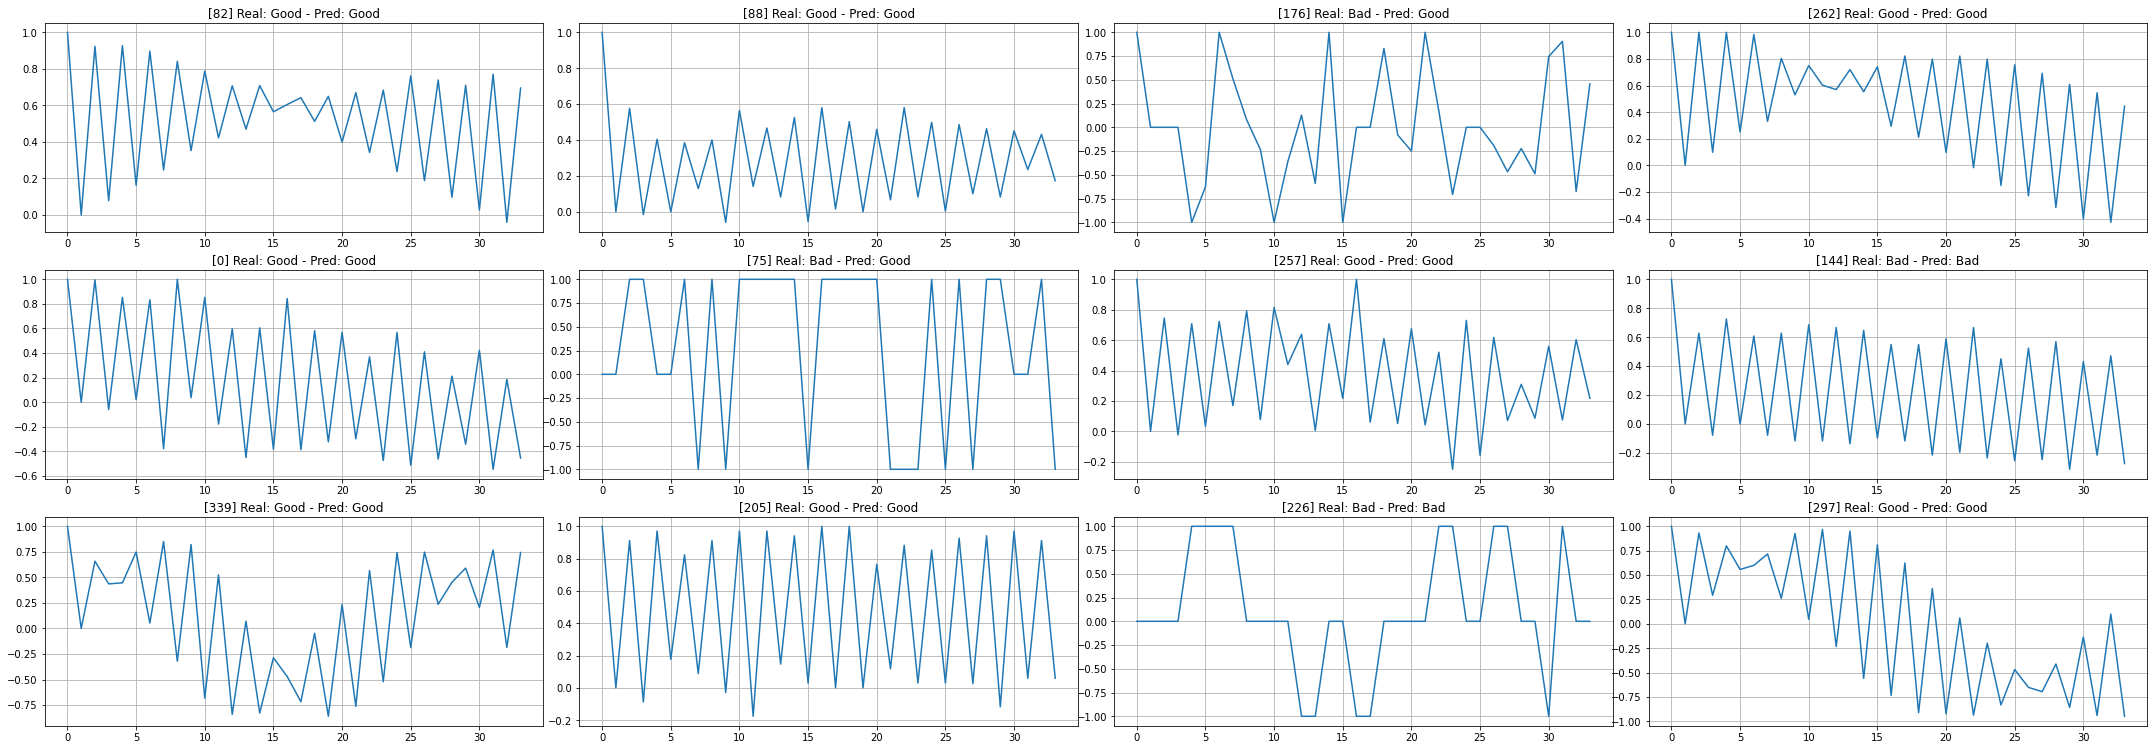

In [18]:
rows, cols = (3, 4)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7.5, rows * 3.5))
axes.flatten()
evaluation_samples = X_test.sample(rows * cols)
evaluation_y_test = y_test[evaluation_samples.index]
evaluation_y_test.index = range(len(evaluation_y_test))

index = 0
for row_index, row in zip(evaluation_samples.index, evaluation_samples.values):
  ax = axes[int(index / cols), int(index % cols)]
  real_pred = reverse_target_dict[evaluation_y_test[index]]
  true_pred = reverse_target_dict[y_pred_xgb[index]]
  ax.set_title(f'[{row_index}] Real: {real_pred} - Pred: {true_pred}')
  ax.grid()
  ax.plot(row)
  index += 1
plt.tight_layout(pad=1.0, h_pad=.5, w_pad=.5)

### Neural networks

In [19]:
import tensorflow as tf

def build_keras(
  display: bool = True
) -> tf.keras.Sequential:
  # architecture
  model = tf.keras.Sequential(
    name='Ionosphere-Classifier',
    layers=[
      tf.keras.layers.Dense(
        units=X_train.shape[1], input_dim=X_train.shape[1], name='Input-Layer'
      ),
      tf.keras.layers.Dense(
        units=X_train.shape[1] * 2, activation='relu', name='Hidden-Layer',
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.L2(1e-4),
        activity_regularizer=tf.keras.regularizers.L2(1e-5)
      ),
      tf.keras.layers.Dense(
        units=128, activation='relu', name='Second-Hidden-Layer',
        kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.L2(1e-4),
        activity_regularizer=tf.keras.regularizers.L2(1e-5)
      ),
      tf.keras.layers.Dense(
        units=1, activation='sigmoid', name='Output-Layer'
      ),
    ]
  )

  # compilation
  model.compile(
    loss=tf.losses.binary_crossentropy,
    # optimizer=tf.optimizers.Adam(learning_rate=0.01),
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
  )

  # explainability
  if display:
    model.summary()

  return model

In [20]:
clf_tf = build_keras()
history = clf_tf.fit(
  X_train,
  y_train,
  epochs=100,
  validation_split=.2,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)],
  # verbose=0,
)

Model: "Ionosphere-Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 34)                1190      
                                                                 
 Hidden-Layer (Dense)        (None, 68)                2380      
                                                                 
 Second-Hidden-Layer (Dense)  (None, 128)              8832      
                                                                 
 Output-Layer (Dense)        (None, 1)                 129       
                                                                 
Total params: 12,531
Trainable params: 12,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 221ms/step - loss: 0.6622 - accuracy: 0.6830 - val_loss: 0.6010 - val_accuracy: 0.6964
Epoch 2/100
7/7 [===============

In [21]:
y_pred_tf = clf_tf.predict(X_test).reshape(1, -1)[0]
y_pred_tf = np.vectorize(lambda x: int(x > .5))(y_pred_tf)

In [22]:
_, tf_accuracy = clf_tf.evaluate(X_test, y_test)
print('normal', tf_accuracy)
print('balanced', balanced_accuracy_score(y_test, y_pred_tf))

3/3 [==============================] - 0s 5ms/step - loss: 0.1857 - accuracy: 0.9577
normal 0.9577465057373047
balanced 0.94


#### Confusion Matrix

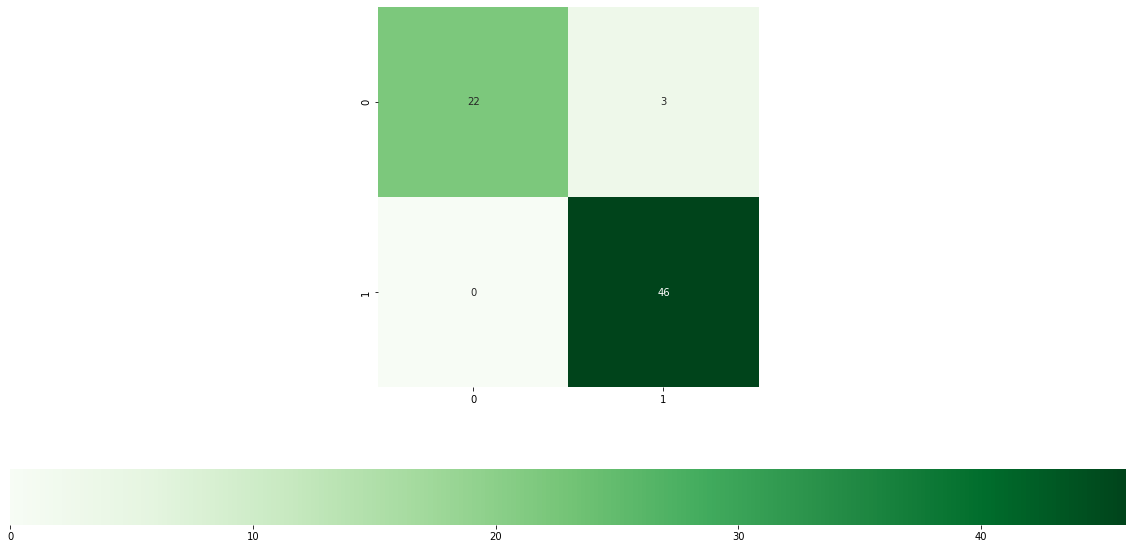

In [23]:
plt.figure(figsize=(20, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_tf), annot=True, square=True, cbar_kws={'orientation': 'horizontal'}, cmap='Greens')

#### Evaluation

In [24]:
y_pred_tf[0]

1

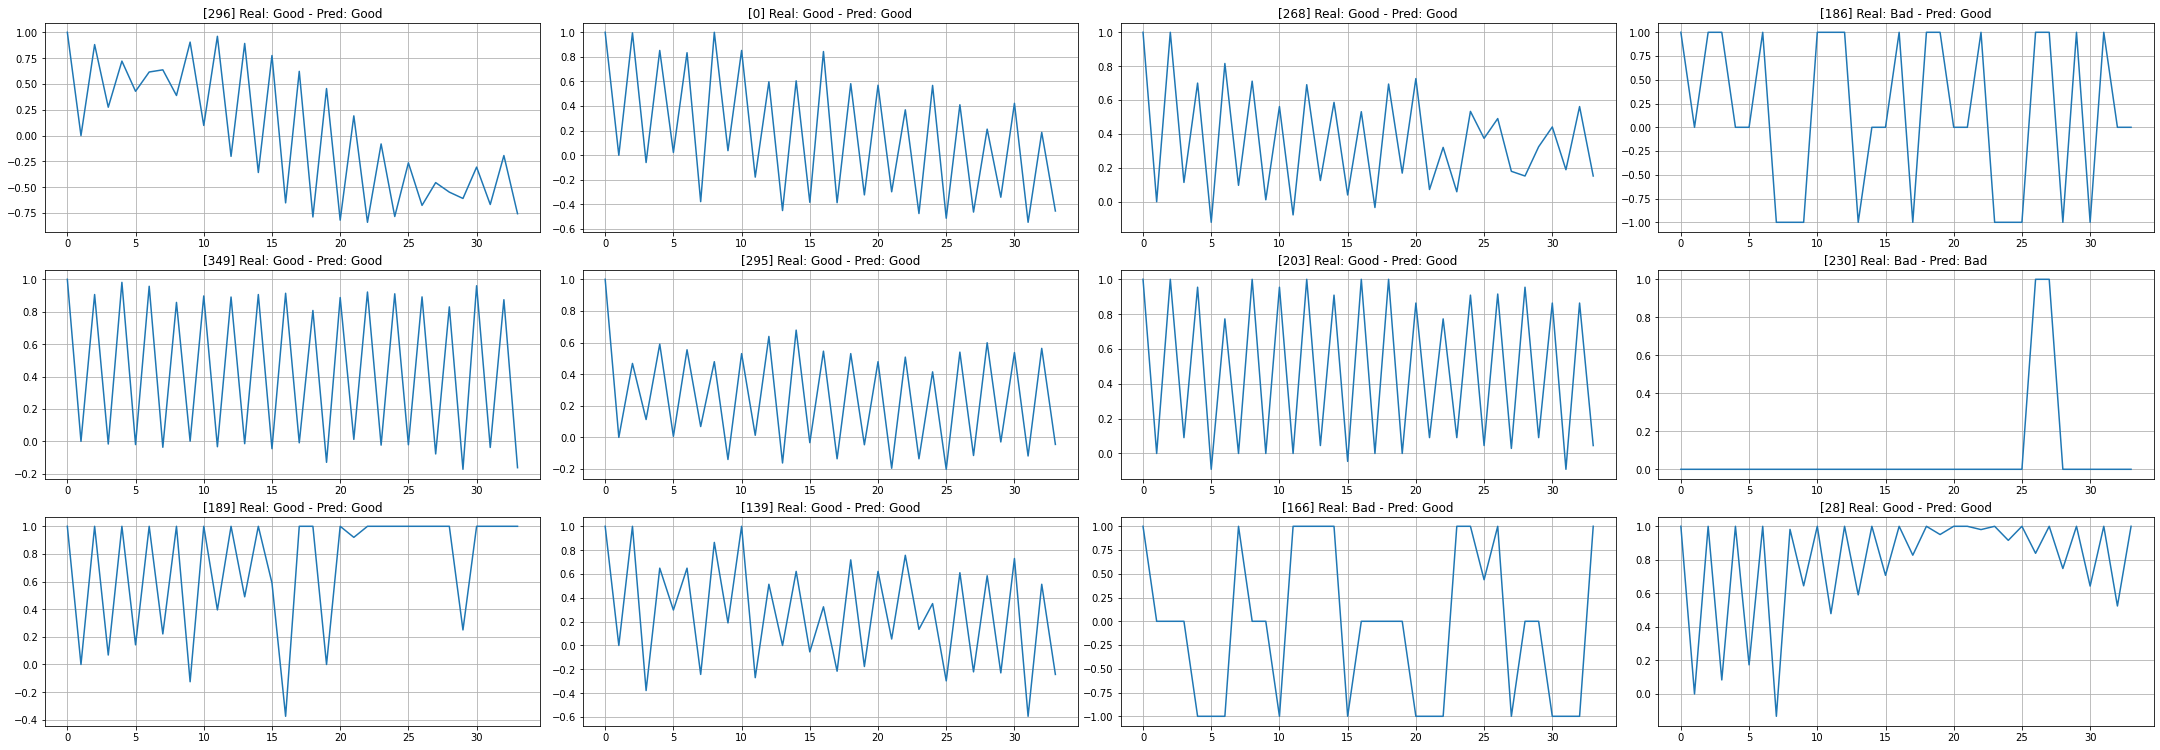

In [25]:
rows, cols = (3, 4)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7.5, rows * 3.5))
axes.flatten()
evaluation_samples = X_test.sample(rows * cols)
evaluation_y_test = y_test[evaluation_samples.index]
evaluation_y_test.index = range(len(evaluation_y_test))
y_pred_tf = y_pred_tf.reshape(1, -1)[0]

index = 0
for row_index, row in zip(evaluation_samples.index, evaluation_samples.values):
  ax = axes[int(index / cols), int(index % cols)]
  real_pred = reverse_target_dict[evaluation_y_test[index]]
  true_pred = reverse_target_dict[y_pred_tf[index]]
  ax.set_title(f'[{row_index}] Real: {real_pred} - Pred: {true_pred}')
  ax.grid()
  ax.plot(row)
  index += 1
plt.tight_layout(pad=1.0, h_pad=.5, w_pad=.5)